In [ ]:
# import libary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

# Choose style for plots
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=[17, 6])


In [46]:

df = pd.read_csv('data/XAU_1d_data.csv', sep=';')


df.columns = df.columns.str.lower()

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print(df.head())
print(f"Null:\n{df.isna().sum()}")


             open   high    low  close  volume
date                                          
2004-06-11  384.0  384.8  382.8  384.1     272
2004-06-14  384.3  385.8  381.8  382.8    1902
2004-06-15  382.8  388.8  381.1  388.6    1951
2004-06-16  387.1  389.8  382.6  383.8    2014
2004-06-17  383.6  389.3  383.0  387.6    1568
Null:
open      0
high      0
low       0
close     0
volume    0
dtype: int64


###  TIME SERIES ANALYSIS – TREND | SEASONALITY | CYCLE | VARIATION

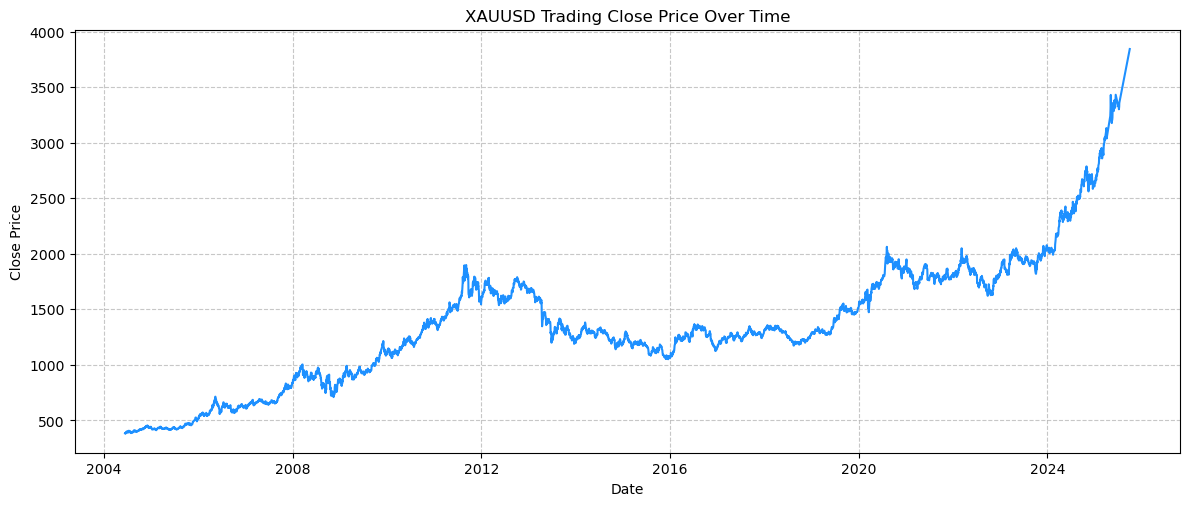

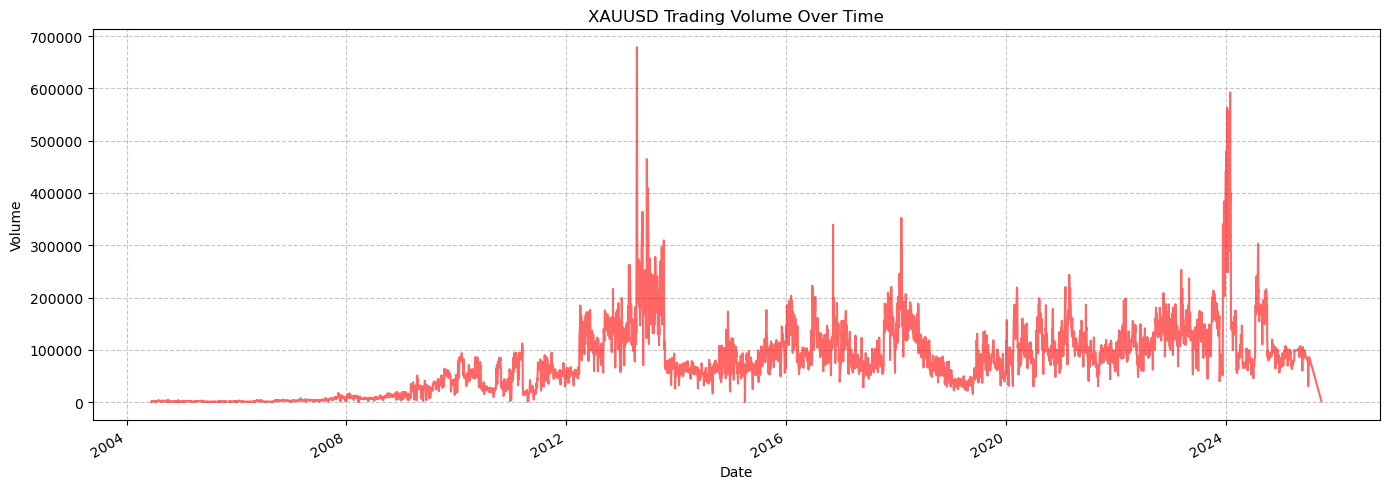

In [68]:
#Close
plt.figure(figsize=(12,5))
plt.plot( df.index, df['close'], label='close', color='dodgerblue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.title('XAUUSD Trading Close Price Over Time')
plt.show()

# Volume
plt.figure(figsize=(14, 5))
df['volume'].plot(title='XAUUSD Trading Volume Over Time', 
                  color='red', 
                  alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Augmented Dickey-Fuller (ADF) test to formally check this.
- Null Hypothesis ($H_0$): The time series is non-stationary (it has a unit root).
- Alternative Hypothesis ($H_1$​): The time series is stationary.

In [64]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Performs and prints the results of the ADF test."""
    print("--- Results of Augmented Dickey-Fuller Test ---")
    result = adfuller(series.dropna())
    
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    
    if result[1] <= 0.05:
        print("Conclusion: Reject H0. The series is likely stationary.")
    else:
        print("Conclusion: Fail to Reject H0. The series is non-stationary.")
    
# Run the test on the 'close' price
adf_test(df['close'])

--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: 3.0796
p-value: 1.0000
Conclusion: Fail to Reject H0. The series is non-stationary.


<Figure size 1400x1000 with 0 Axes>

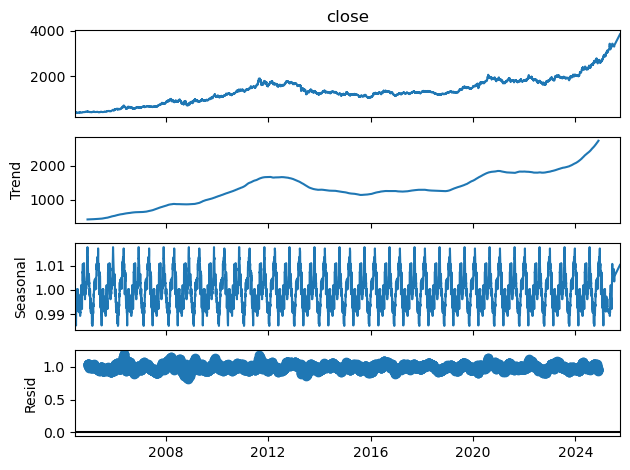

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the 'close' price series (using the Multiplicative model)
# We assume a periodicity of 252 (number of trading days in a year)
decomposition = seasonal_decompose(df['close'], model='multiplicative', period=252)

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

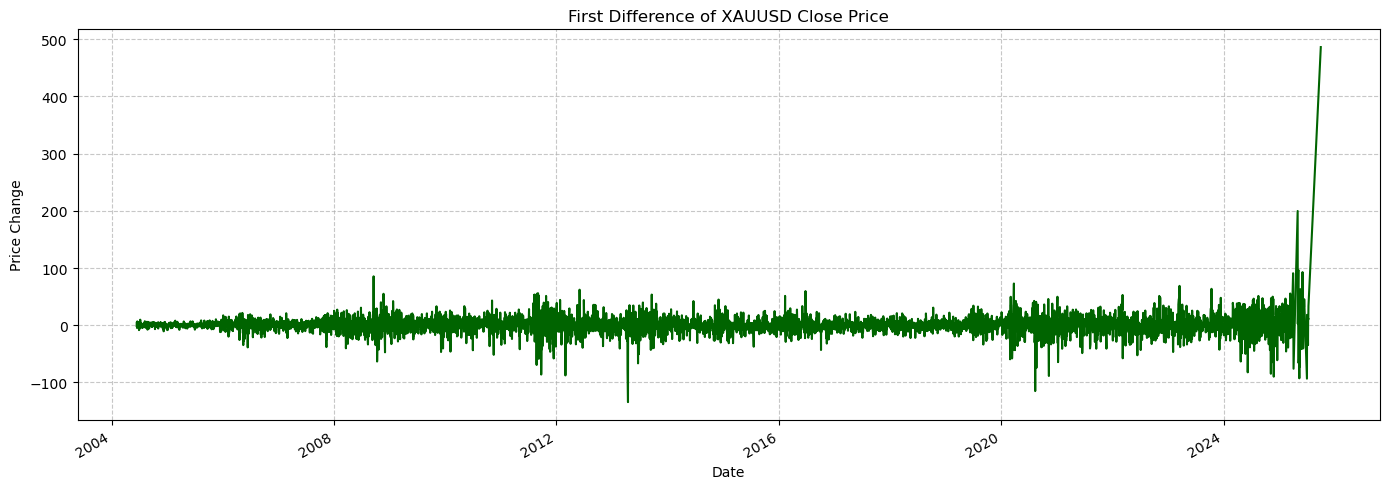


--- Testing Stationarity of the DIFFERENCED Series ---
--- Results of Augmented Dickey-Fuller Test ---
ADF Statistic: -11.2401
p-value: 0.0000
Conclusion: Reject H0. The series is likely stationary.


In [60]:
# Calculate the first difference of the close price
df['close_diff'] = df['close'].diff(periods=1)

# Plot the differenced series
plt.figure(figsize=(14, 5))
df['close_diff'].plot(title='First Difference of XAUUSD Close Price', 
                      color='darkgreen', 
                      linewidth=1.5)
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Test the differenced series for stationarity
print("\n--- Testing Stationarity of the DIFFERENCED Series ---")
adf_test(df['close_diff'])

Step	Result	Conclusion
Original ADF Test	p-value = 1.0000	Non-Stationary. The price level itself is unsuitable for ARIMA modeling.
Decomposition	Strong Trend (increasing over time). Visible Seasonal pattern (repeating yearly cycle). Residuals look relatively random.	Confirms the need to remove the trend. The seasonal component suggests a SARIMA model might be required.
Differenced ADF Test	p-value = 0.0000	Stationary. The first difference of the price is stationary, meaning the differencing order d=1 is sufficient for the non-seasonal part of the model.

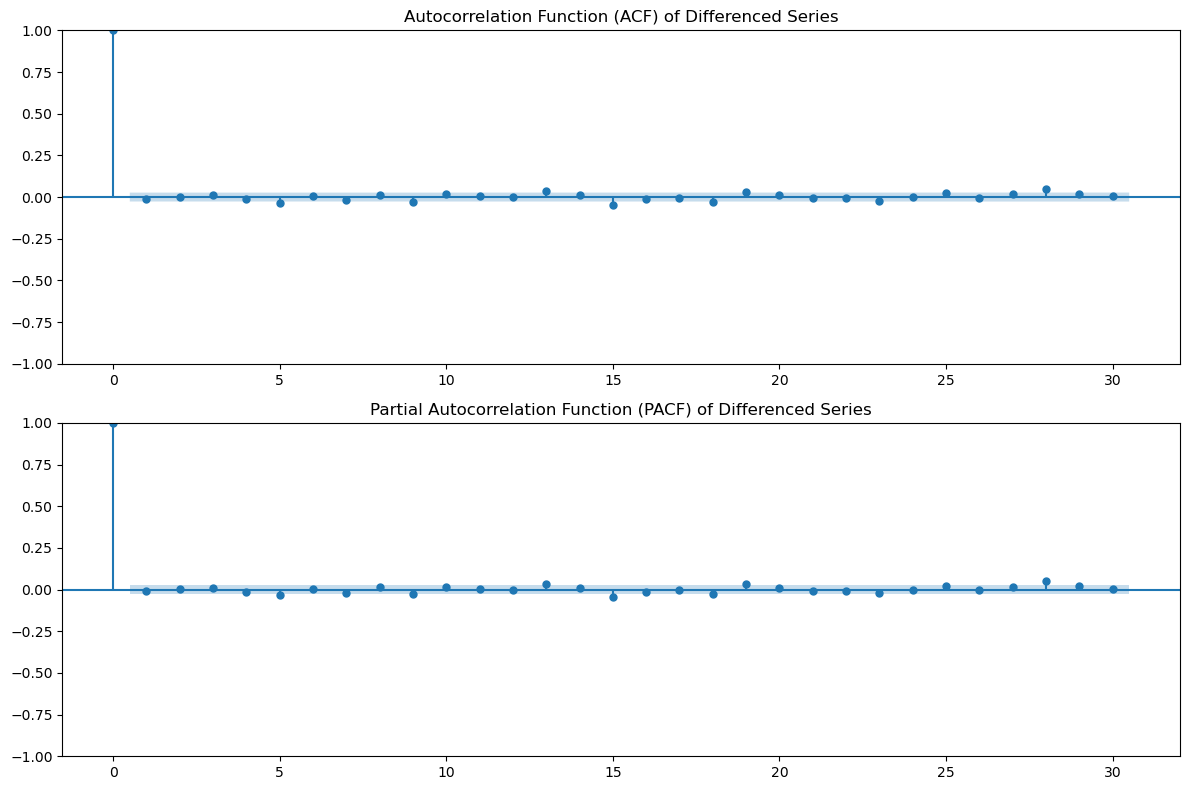

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure you use the stationary series (the first difference)
stationary_series = df['close_diff'].dropna()

# Create plots for ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrelation Function (ACF) plot
plot_acf(stationary_series, lags=30, ax=axes[0], title='Autocorrelation Function (ACF) of Differenced Series')

# Partial Autocorrelation Function (PACF) plot
plot_pacf(stationary_series, lags=30, ax=axes[1], title='Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()

c:\Users\VAQ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\VAQ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\VAQ\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 5383
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22745.379
Date:                Tue, 07 Oct 2025   AIC                          45496.758
Time:                        21:14:14   BIC                          45516.531
Sample:                             0   HQIC                         45503.663
                               - 5383                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1240      1.002      0.124      0.902      -1.839       2.087
ma.L1         -0.1327      1.000     -0.133      0.894      -2.092       1.827
sigma2       274.5654      0.680    403.985      0.0

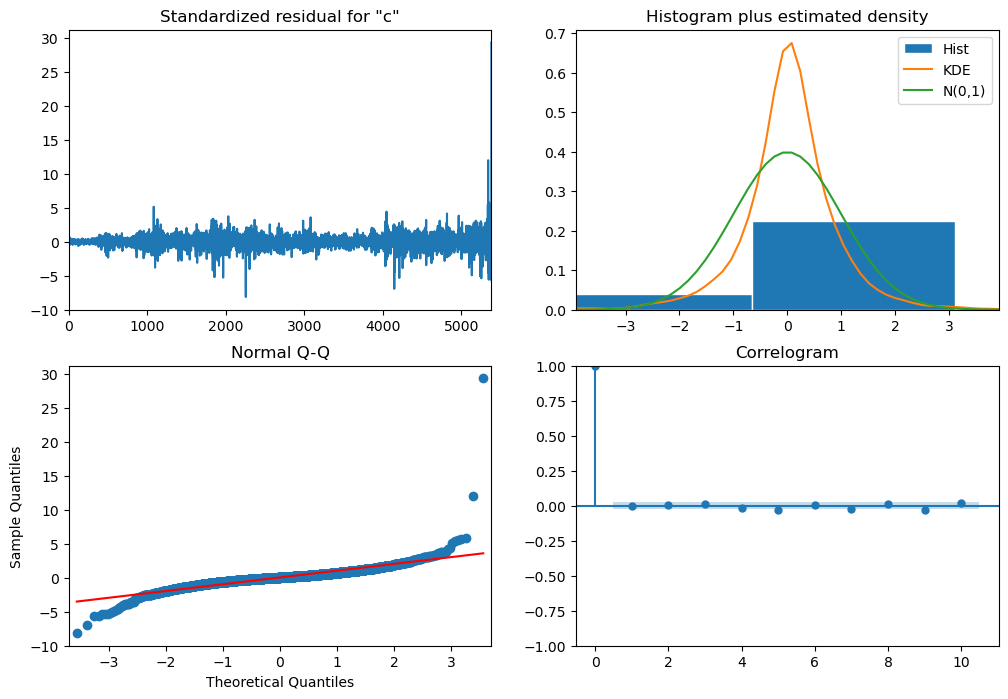

In [70]:
# ASSUMING you found p=1 and q=1 from the plots, for example:
p, d, q = 1, 1, 1

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['close'], order=(p, d, q))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()